Using device: cpu


<Figure size 800x600 with 0 Axes>

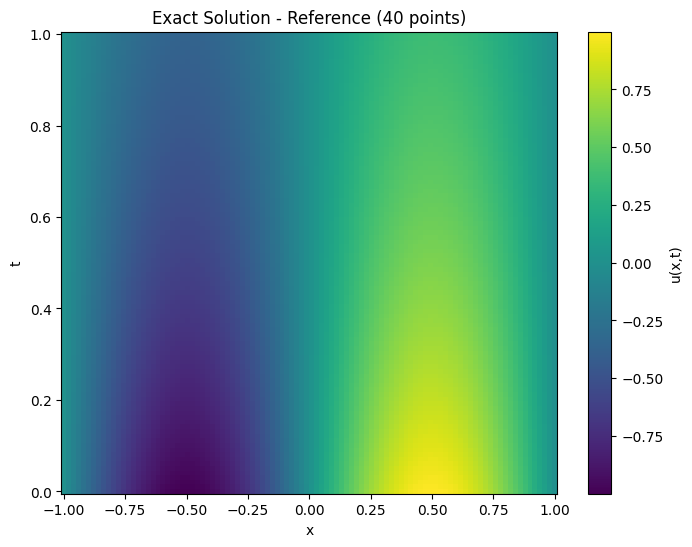

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from tqdm.auto import tqdm, trange
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from tqdm.notebook import tqdm, trange

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class DiffusionPINN(torch.nn.Module):
    def __init__(self, hidden_layers, neurons_per_layer):
        super().__init__()
        layers = []
        layers.append(torch.nn.Linear(2, neurons_per_layer))
        layers.append(torch.nn.Tanh())
        
        for _ in range(hidden_layers):
            layers.append(torch.nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(torch.nn.Tanh())
            
        layers.append(torch.nn.Linear(neurons_per_layer, 1))
        
        self.network = torch.nn.Sequential(*layers)
        
    def forward(self, x, t):
        input_tensor = torch.cat([x, t], dim=1)
        return self.network(input_tensor)
    
    def compute_pde_residual(self, x, t):
        x = x.requires_grad_(True)
        t = t.requires_grad_(True)
        
        u = self.forward(x, t)
        
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
        
        source_term = torch.exp(-t) * (-torch.sin(np.pi * x) + np.pi**2 * torch.sin(np.pi * x))
        residual = u_t - u_xx - source_term
        
        return residual

def generate_training_points(n_points, method='grid'):
    if method == 'grid':
        n_points_1d = int(np.sqrt(n_points))
        x = np.linspace(-1, 1, n_points_1d)
        t = np.linspace(0, 1, n_points_1d)
        X, T = np.meshgrid(x, t)
        x_tensor = torch.tensor(X.flatten()[:, None], dtype=torch.float32, device=device)
        t_tensor = torch.tensor(T.flatten()[:, None], dtype=torch.float32, device=device)
        return x_tensor, t_tensor
    
    elif method == 'random':
        x = np.random.uniform(-1, 1, (n_points, 1))
        t = np.random.uniform(0, 1, (n_points, 1))
        return torch.tensor(x, dtype=torch.float32, device=device), torch.tensor(t, dtype=torch.float32, device=device)
    
    elif method in ['lhs', 'halton', 'sobol']:
        if method == 'lhs':
            sampler = qmc.LatinHypercube(d=2)
        elif method == 'halton':
            sampler = qmc.Halton(d=2)
        else:
            sampler = qmc.Sobol(d=2)
        samples = sampler.random(n=n_points)
        x = 2 * samples[:, 0:1] - 1
        t = samples[:, 1:2]
        return torch.tensor(x, dtype=torch.float32, device=device), torch.tensor(t, dtype=torch.float32, device=device)

def plot_solution(model, method, n_points, exact=False):
    n_test = 100
    x = torch.linspace(-1, 1, n_test, device=device)
    t = torch.linspace(0, 1, n_test, device=device)
    X, T = torch.meshgrid(x, t, indexing='ij')
    
    X_flat = X.reshape(-1, 1)
    T_flat = T.reshape(-1, 1)
    
    with torch.no_grad():
        if exact:
            U = torch.sin(np.pi * X_flat) * torch.exp(-T_flat)
        else:
            U = model(X_flat, T_flat)
        U = U.reshape(n_test, n_test).cpu().numpy()
    
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(X.cpu().numpy(), T.cpu().numpy(), U, shading='auto', cmap='viridis')
    plt.colorbar(label='u(x,t)')
    plt.xlabel('x')
    plt.ylabel('t')
    title = f'{"Exact" if exact else "Predicted"} Solution - {method} ({n_points} points)'
    plt.title(title)
    return U

def compute_l2_error(model, n_test_points=1000):
    x_test = torch.linspace(-1, 1, n_test_points, device=device).reshape(-1, 1)
    t_test = torch.linspace(0, 1, n_test_points, device=device).reshape(-1, 1)
    X_test, T_test = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
    
    x_test = X_test.reshape(-1, 1)
    t_test = T_test.reshape(-1, 1)
    
    with torch.no_grad():
        u_pred = model(x_test, t_test)
        u_exact = torch.sin(np.pi * x_test) * torch.exp(-t_test)
        
    error = torch.norm(u_pred - u_exact) / torch.norm(u_exact)
    return error.item()

def train_pinn(n_collocation, sampling_method):
    print(f"\nTraining with {sampling_method} sampling, {n_collocation} points")
    model = DiffusionPINN(hidden_layers=4, neurons_per_layer=50).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    x_collocation, t_collocation = generate_training_points(n_collocation, sampling_method)
    
    n_boundary = 100
    x_boundary = torch.linspace(-1, 1, n_boundary, device=device).reshape(-1, 1)
    t_boundary = torch.zeros(n_boundary, 1, device=device)
    
    pbar = trange(15000, desc='Training', dynamic_ncols=False)
    for epoch in pbar:
        optimizer.zero_grad()
        
        residual = model.compute_pde_residual(x_collocation, t_collocation)
        pde_loss = torch.mean(residual**2)
        
        u_initial = model(x_boundary, t_boundary)
        ic_loss = torch.mean((u_initial - torch.sin(np.pi * x_boundary))**2)
        
        t_bc = torch.linspace(0, 1, n_boundary, device=device).reshape(-1, 1)
        u_left = model(torch.ones_like(t_bc, device=device) * -1, t_bc)
        u_right = model(torch.ones_like(t_bc, device=device), t_bc)
        bc_loss = torch.mean(u_left**2 + u_right**2)
        
        loss = pde_loss + ic_loss + bc_loss
        
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            pbar.set_postfix({'loss': f'{loss.item():.2e}'})
    
    return model, compute_l2_error(model)

# Compare different sampling methods
sampling_methods = ['grid', 'random', 'lhs', 'halton', 'sobol']
n_points_range = [10, 20, 40, 60, 80]
results = {method: [] for method in sampling_methods}
models = {}  # Store models for visualization

# Plot exact solution
plt.figure(figsize=(8, 6))
n_viz = 40  # Points for visualization
_, _ = generate_training_points(n_viz, 'grid')
plot_solution(None, 'Reference', n_viz, exact=True)
plt.show()

# Training loop with progress bar
for n_points in tqdm(n_points_range, desc='Points'):
    for method in tqdm(sampling_methods, desc='Methods', leave=False):
        model, error = train_pinn(n_points, method)
        results[method].append(error)
        
        # Store model for middle point count for visualization
        if n_points == 40:
            models[method] = model

# Plot results
plt.figure(figsize=(12, 6))
for method in sampling_methods:
    plt.plot(n_points_range, results[method], label=method, marker='o')

plt.yscale('log')
plt.xlabel('No. of residual points')
plt.ylabel('L² relative error')
plt.legend()
plt.grid(True)
plt.title('Comparison of Sampling Methods')
plt.show()

# Visualize solutions for each method at n=40
plt.figure(figsize=(15, 10))
for idx, (method, model) in enumerate(models.items(), 1):
    plt.subplot(2, 3, idx)
    plot_solution(model, method, 40)
plt.tight_layout()
plt.show()

# Print final errors for each method
print("\nFinal L² errors:")
for method in sampling_methods:
    print(f"{method:10s}: {results[method][-1]:.2e}")